# Data Wranglig for Capstone Two Project 
## Project: Loan Default Prediction

LendingClub is a US peer-to-peer lending company. It was the first peer-to-peer lender to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform which specializes in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Identifying the customers who are prone to default their loan ensures the company to enhance its financial standing. Failure in rejecting those who do not have the required qualifications and rejecting the applications who are eligible for the loans result in financial losses. Developing an accurate predictive model is required for the success of applicant’s screening. This credit grade along with other factors determine the interest rate and the loan amount. Allowable loan range was between $1,000–40,000 and the return period was 3 or 5 years. Investors would make money from interest rates which were varied from 6.03% to 26.06%. LendingClub would make money from charging an origination fee to its borrowers and a service fee to its investors. The interest rates that LendingCub was offering were better for borrowers and lenders than most of banks and therefore, it was highly received.

When a request was made, based on the requester’s information such as credit history, LendingClub would decide to either accept or reject the request. For the accepted loans, a credit grade ranging from A to G would be assigned. The credit grade along with other factors would determine the interest rate. For the rejected loan a risk score was assigned. Furthermore, the credit grade would also determine the amount of the origination fee that the requester would be charged, and it would be between 1.1–5.0% of the loan amount. The size of the service fee, that the investor would be charged, would be 1% of all amounts the borrower would pay, which was the requested amount plus the total interest. Therefore, higher interest rates would generate more revenue. However, higher interest rates also indicate a riskier loan which may end up on default and may cause investment loss for LendingClub. Therefore, having a method to predict the risk factor accurately is very desirable. Statistical data shows that about 10% of loans will be defaulted. The question is if we can have a better risk analysis method and ultimately a strong predictive model to decrease loan default ratio by 50% in the next three years.

### 1. Import packages

In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
#from library.sb_utils import save_file
sns.set_palette(sns.color_palette())

In [407]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [408]:
%watermark -a "Saeed Rafieepour" -d -t -v -p numpy,pandas

Author: Saeed Rafieepour

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.20.0

numpy : 1.26.4
pandas: 2.2.0



### Useful Functions

In [409]:
# description of some columns
def feature_describe(feat_names=['loan_amnt','funded_amnt','funded_amnt_inv']):
    """ Returns the features description having the features names"""
    LCDataDictionary = pd.read_excel(data2, sheet_name=None)
    LCDataDictionary['browseNotes'].columns=['LoanStatNew', 'Description']
    df_desc = LCDataDictionary['LoanStats']
    #df_desc = pd.concat([LCDataDictionary['LoanStats'], LCDataDictionary['browseNotes']], axis=0)
    df_desc.LoanStatNew = df_desc.LoanStatNew.str.strip()
    
    for item in feat_names:
        if item not in df_desc.iloc[:,0].values:
            #raise Exception(f'{item} is not in the list!') 
            print(f'{item} is not in the list!')
            feat_names.remove(item)
    return df_desc[df_desc.LoanStatNew.isin(feat_names)]

In [410]:
# separating object variables vs numeric variables
def get_data_type(df):
    """ Returns the data types of each column in dataframe as a dictionary"""
    float64_dtype = df.select_dtypes(include=['float64']).columns.to_list()
    int64_dtype = df.select_dtypes(include=['int64']).columns.to_list()
    object_dtype = df.select_dtypes(include=['object']).columns.to_list()
    return {'float64_dtype':float64_dtype,'int64_dtype':int64_dtype, 'object_dtype':object_dtype}

In [411]:
def category_to_numeric_convertor(df):
    '''This function converts the categorial features to numeric equivalents''' 
    object_dtype = df.select_dtypes(include=['object'])
    object_dtype_cat = object_dtype.apply(lambda col:col.astype('category'))
    object_dtype_categorized = object_dtype_cat.apply(lambda col:col.cat.codes)
    return object_dtype_categorized

In [412]:
def get_missing_data(df):
    '''This function returns missing percentage of each column in the original dataframe''' 
    missing_data = pd.concat([df.isna().sum(), 100 * df.isna().mean()], axis=1)
    missing_data.columns = ['count', 'missing %']
    return missing_data.sort_values(by='count', ascending=False)

In [577]:
def stringdate_to_datetime(df,date_columns):
    '''This function converts string date columns to the datetime format''' 
    df_new_datecol = df[date_columns].apply(lambda col:pd.to_datetime(col, format='mixed'))
    #df_new_datecol = df[date_columns]
    for col in date_columns:
        df_new_datecol[col] = pd.to_datetime(df_new_datecol[col].apply(lambda col:col.strftime("%Y-%m")),format="%Y-%m")
        #df_new_datecol[col]= pd.to_datetime(df_new_datecol[col],format="%Y-%m", errors='coerce').dt.strftime("%Y-%m")
    #https://stackoverflow.com/questions/58948809/why-do-i-get-valueerror-nattype-does-not-support-strftime-even-though-its-no

    df[date_columns] = df_new_datecol
    return df

In [414]:
def get_unique_objectdtypes(df):
    '''This function returns the unique values of columns with object data type''' 
    df_object_dtype = df[get_data_type(df)['object_dtype']]
    object_dtype_unique = df_object_dtype.apply(lambda col: col.unique()).to_frame(name= 'Unique_Categories')
    object_dtype_nunique = df_object_dtype.apply(lambda col: col.nunique())
    return object_dtype_unique, object_dtype_nunique

In [415]:
def get_xpercent_missing_data(df, percentage):
    '''This function returns missing percentage of each column in the original dataframe''' 
    missing_data = get_missing_data(df)
    ## missing values less than percent%
    col_lessthan_xperc = missing_data[~(missing_data['missing %'] > percentage)] 
    col_morethan_xperc = missing_data[missing_data['missing %'] > percentage] 
    return col_lessthan_xperc, col_morethan_xperc

### 2. Data Collection

The dataset used for this project is from Kaggle website. The dataset has 2,260,701 observations of loans granted between 2007 to 2018 with 151 features which include information about applicants such as credit score, income, and employment, as well as data about loans, such as their amounts, and terms.
https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv/code

In [416]:
current_dir = os.getcwd()
arr = os.listdir()

In [417]:
# PROJ_ROOT = os.path.join(current_dir, os.pardir, os.pardir)
PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [418]:
# src_dir = os.path.join(current_dir, os.pardir, os.pardir, "src")
src_dir = os.path.join(PROJ_ROOT, "src")
data1 = os.path.join(PROJ_ROOT,
                              "data",
                              "raw",
                              "accepted_2007_to_2018Q4.csv")
data2 = os.path.join(PROJ_ROOT,
                              "data",
                              "raw",
                              "LCDataDictionary.xlsx")

In [419]:
# add local python functions
sys.path.append(src_dir)
sys.path.append(data1)
sys.path.append(data2)

In [420]:
loan_data = pd.read_csv(data1)

### 3. Feature Exploration

In [421]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [422]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [423]:
loan_data.describe().T

,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2260668.0,15046.931228,9190.245488,5.000000e+02,8000.0000,12900.000,20000.000000,4.000000e+04
funded_amnt,2260668.0,15041.664057,9188.413022,5.000000e+02,8000.0000,12875.000,20000.000000,4.000000e+04
funded_amnt_inv,2260668.0,15023.437745,9192.331679,0.000000e+00,8000.0000,12800.000,20000.000000,4.000000e+04
int_rate,2260668.0,13.092829,4.832138,5.310000e+00,9.4900,12.620,15.990000,3.099000e+01
installment,2260668.0,445.806823,267.173535,4.930000e+00,251.6500,377.990,593.320000,1.719830e+03
annual_inc,2260664.0,77992.428687,112696.199574,0.000000e+00,46000.0000,65000.000,93000.000000,1.100000e+08
dti,2258957.0,18.824196,14.183329,-1.000000e+00,11.8900,17.840,24.490000,9.990000e+02
delinq_2yrs,2260639.0,0.306879,0.867230,0.000000e+00,0.0000,0.000,0.000000,5.800000e+01
fico_range_low,2260668.0,698.588205,33.010376,6.100000e+02,675.0000,690.000,715.000000,8.450000e+02


In [424]:
#loan_data.columns
print(loan_data.columns.to_list())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

#### Checking for data types

In [425]:
# using get_data_type to get the data type for each column
get_data_type(loan_data)

{'float64_dtype': ['member_id',
  'loan_amnt',
  'funded_amnt',
  'funded_amnt_inv',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'delinq_2yrs',
  'fico_range_low',
  'fico_range_high',
  'inq_last_6mths',
  'mths_since_last_delinq',
  'mths_since_last_record',
  'open_acc',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'total_acc',
  'out_prncp',
  'out_prncp_inv',
  'total_pymnt',
  'total_pymnt_inv',
  'total_rec_prncp',
  'total_rec_int',
  'total_rec_late_fee',
  'recoveries',
  'collection_recovery_fee',
  'last_pymnt_amnt',
  'last_fico_range_high',
  'last_fico_range_low',
  'collections_12_mths_ex_med',
  'mths_since_last_major_derog',
  'policy_code',
  'annual_inc_joint',
  'dti_joint',
  'acc_now_delinq',
  'tot_coll_amt',
  'tot_cur_bal',
  'open_acc_6m',
  'open_act_il',
  'open_il_12m',
  'open_il_24m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'il_util',
  'open_rv_12m',
  'open_rv_24m',
  'max_bal_bc',
  'all_util',
  'total_rev_hi_lim',
  'inq_fi',
  't

In [426]:
# the size of each column data types
[(i,len(get_data_type(loan_data)[i])) for i in get_data_type(loan_data).keys()]

[('float64_dtype', 113), ('int64_dtype', 0), ('object_dtype', 38)]

There is an excel file for feature description and we have written a function to get the description of features

In [427]:
pd.options.display.max_colwidth = None
feature_describe(['emp_title', 'open_rv_24m', 'hardship_length', 'disbursement_method'])

,LoanStatNew,Description
20,emp_title,The job title supplied by the Borrower when applying for the loan.*
79,open_rv_24m,Number of revolving trades opened in past 24 months
137,hardship_length,The number of months the borrower will make smaller payments than normally obligated due to a hardship plan
143,disbursement_method,"The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY"


#### Number Of Missing Values By Column
In this section we return a pandas dataframe for the number and percentage of missing values

In [428]:
missing_data = get_missing_data(loan_data)

In [429]:
#### just showing the columns where have missing values
only_missingcolumns = missing_data[missing_data['count']!=0].sort_values(by='count', ascending=False)
pd.set_option('display.max_rows', only_missingcolumns.shape[0]+1)
print(only_missingcolumns, '\n', f'The number of columns with missing values is: {only_missingcolumns.shape[0]}')

                                              count   missing %
member_id                                   2260701  100.000000
orig_projected_additional_accrued_interest  2252050   99.617331
hardship_payoff_balance_amount              2249784   99.517097
hardship_amount                             2249784   99.517097
payment_plan_start_date                     2249784   99.517097
hardship_length                             2249784   99.517097
hardship_dpd                                2249784   99.517097
hardship_loan_status                        2249784   99.517097
hardship_last_payment_amount                2249784   99.517097
deferral_term                               2249784   99.517097
hardship_status                             2249784   99.517097
hardship_reason                             2249784   99.517097
hardship_type                               2249784   99.517097
hardship_start_date                         2249784   99.517097
hardship_end_date                       

#### Which columns to keep or drop?
We categorize based on the percentage of the missing values.

1. More than 75% missing
2. Between 50% and 75%
3. Between 38% and 50%
4. <38% missing


#### Category 1: Columns with 75% and more missing values

In [430]:
less75_missing, more75_missing = get_xpercent_missing_data(loan_data, 75)

In [431]:
# columns with more than 75% missing values
print(more75_missing, '\n', more75_missing.shape[0])

                                              count   missing %
member_id                                   2260701  100.000000
orig_projected_additional_accrued_interest  2252050   99.617331
hardship_end_date                           2249784   99.517097
hardship_start_date                         2249784   99.517097
hardship_type                               2249784   99.517097
hardship_reason                             2249784   99.517097
hardship_status                             2249784   99.517097
deferral_term                               2249784   99.517097
hardship_last_payment_amount                2249784   99.517097
hardship_payoff_balance_amount              2249784   99.517097
hardship_loan_status                        2249784   99.517097
hardship_dpd                                2249784   99.517097
hardship_length                             2249784   99.517097
payment_plan_start_date                     2249784   99.517097
hardship_amount                         

In [432]:
more75_missing.index.to_list()

['member_id',
 'orig_projected_additional_accrued_interest',
 'hardship_end_date',
 'hardship_start_date',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_last_payment_amount',
 'hardship_payoff_balance_amount',
 'hardship_loan_status',
 'hardship_dpd',
 'hardship_length',
 'payment_plan_start_date',
 'hardship_amount',
 'settlement_term',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util',
 'revol_bal_joint',
 'sec_app_mort_acc',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_open_acc',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'verification_status_joint',
 'dti_joint',
 'annual_inc_joint',
 'desc',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq']

In [433]:
# Description of the features more than 75% missing values
#pd.set_option('display.max_colwidth', -1)  # the folowing is equivalent to this
pd.options.display.max_colwidth = None
feature_describe(more75_missing.index.to_list())

verification_status_joint is not in the list!


,LoanStatNew,Description
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
15,desc,Loan description provided by the borrower
17,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"
44,member_id,A unique LC assigned Id for the borrower member.
52,mths_since_last_record,The number of months since the last public record.
55,mths_since_recent_bc_dlq,Months since most recent bankcard delinquency
115,revol_bal_joint,"Sum of revolving credit balance of the co-borrowers, net of duplicate balances"
116,sec_app_fico_range_low,FICO range (high) for the secondary applicant
117,sec_app_fico_range_high,FICO range (low) for the secondary applicant
118,sec_app_earliest_cr_line,Earliest credit line at time of application for the secondary applicant


Based on the above analysis of missing values, it seems that most of the variables with missing values more than 75% are either metadata or related to hardship plans (payment in small values). Also, some columns are related to joint accounts (secondary applicants) and have lots of missing values (dti_joint, etc). So we can drop all these columns. We also try to focus on the single applications and so the joint types are dropped (later). 

#### Filter columns with more than 75% of missing values

In [434]:
col_less_75percent_na = less75_missing.index.values
loan_less_75perc_na = loan_data[col_less_75percent_na]

In [435]:
print(loan_less_75perc_na.shape)

(2260701, 111)


#### Category 2: Columns between 50% and 75% missing values

In [436]:
less50_missing, btw50and75_missing = get_xpercent_missing_data(loan_less_75perc_na, 50)

In [437]:
btw50and75_missing

,count,missing %
mths_since_last_major_derog,1679926,74.309960
mths_since_recent_revol_delinq,1520342,67.250910
next_pymnt_d,1345343,59.509993
mths_since_last_delinq,1158535,51.246715


Let's see what these features are:

In [438]:
pd.options.display.max_colwidth = None
feature_describe(btw50and75_missing.index.to_list())

,LoanStatNew,Description
50,mths_since_last_delinq,The number of months since the borrower's last delinquency.
51,mths_since_last_major_derog,Months since most recent 90-day or worse rating
57,mths_since_recent_revol_delinq,Months since most recent revolving delinquency.
58,next_pymnt_d,Next scheduled payment date


The above features are somehow important, but since the data are for number of months that people have had delinquencies, next payment due date, their imputation will not be very helpful. Also these columns include over 1 million null values.

In [439]:
col_less_50percent_na = less50_missing.index.values
loan_less_50perc_na = loan_less_75perc_na[col_less_50percent_na]

In [440]:
print(loan_less_50perc_na.shape)

(2260701, 107)


#### Category 3: Columns between 38% and 50% missing values

In [441]:
less38_missing, btw38and50_missing = get_xpercent_missing_data(loan_less_50perc_na, 38)

Let's see what these features are:

In [442]:
btw38and50_missing

,count,missing %
il_util,1068883,47.281042
mths_since_rcnt_il,909957,40.251099
all_util,866381,38.323555
open_acc_6m,866163,38.313912
total_cu_tl,866163,38.313912
inq_last_12m,866163,38.313912
open_il_24m,866162,38.313868
open_rv_12m,866162,38.313868
total_bal_il,866162,38.313868
open_rv_24m,866162,38.313868


In [443]:
pd.options.display.max_colwidth = None
feature_describe(btw38and50_missing.index.to_list())

,LoanStatNew,Description
3,all_util,Balance to credit limit on all trades
28,il_util,Ratio of total current balance to high credit/credit limit on all install acct
30,inq_fi,Number of personal finance inquiries
31,inq_last_12m,Number of credit inquiries in past 12 months
43,max_bal_bc,Maximum current balance owed on all revolving accounts
53,mths_since_rcnt_il,Months since most recent installment accounts opened
74,open_acc_6m,Number of open trades in last 6 months
75,open_il_12m,Number of installment accounts opened in past 12 months
76,open_il_24m,Number of installment accounts opened in past 24 months
77,open_act_il,Number of currently active installment trades


#### Category 4: Columns less than 38% missing values

In [444]:
less38_missing

,count,missing %
mths_since_recent_inq,295468,13.069751
emp_title,167002,7.387178
num_tl_120dpd_2m,153690,6.798334
emp_length,146940,6.499754
mo_sin_old_il_acct,139104,6.153136
bc_util,76104,3.366389
percent_bc_gt_75,75412,3.335779
bc_open_to_buy,74968,3.316140
mths_since_recent_bc,73445,3.248771
pct_tl_nvr_dlq,70464,3.116909


Let's examine all the features with less than 50% null values:

In [445]:
pd.options.display.max_colwidth=None
feature_describe(less50_missing.index.values)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
10,chargeoff_within_12_mths,Number of charge-offs within 12 months


Some features can be dropped as they do not convey any information regarding the loan default such as:
['url', 'id', 'policy_code']

In [446]:
loan_less_50perc_na.drop(['url', 'id', 'policy_code'], axis=1, inplace=True)

We could convert the zip_codes using the following code to only have the first 3 digits:
Converting zipcodes to only numbers by removing the xx from the end of them:
loan_data_less75perc_na_.zip_code = loan_data_less75perc_na_.zip_code.str.replace("xx","")

zip_code column can be dropped too, as we do not have the actual zipcodes and what we have is the first three-digits. We have the state for the location information.

In [447]:
loan_less_50perc_na.drop('zip_code', axis=1, inplace=True)

The purpose of the current work is to find out who make default based on the information provided in the applicant's forms. Some of the features listed are time-related as are for the time after a loan was granted. Such as open_rv_6m, open_rv_12m, open_rv_24m, open_il_12m, last_fico_high, etc. Basically, everything that includes rcnt, cur, last, etc. As hardship is a post-approval approach that some borrowers take to have a relief in their payments. We will remove this feature. It is also not important how the money was paid to the borrower, so disbursement_method is dropped too. The debt_settlement_flag is removed too. 


The list of features we will keep is given below:


''''
a = set(loan_less_50perc_na).difference(keeplist)
b = set(a).difference(object_dtype)
get_missing_data(loan_less_50perc_na[list(b)])


in_obj_not_keeplist = list(set(object_dtype).difference(keeplist))
keeplist1 = keeplist
keeplist1.extend(['tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs', 'delinq_amnt','acc_now_delinq','bc_util'])
not_in_keep_list_but_in_50_perc = ['tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs', 'delinq_amnt','acc_now_delinq','bc_util']
'''

In [448]:
features_to_keep = ['revol_util', 'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 'earliest_cr_line', 'open_acc',
                    'mort_acc', 'annual_inc', 'issue_d', 'grade', 'sub_grade', 'funded_amnt', 'loan_status', 'installment', 'int_rate', 'term', 
                    'revol_bal', 'fico_range_high', 'fico_range_low', 'emp_length', 'home_ownership', 'funded_amnt_inv', 'num_rev_accts', 
                    'pub_rec_bankruptcies', 'tax_liens', 'addr_state', 'loan_amnt','initial_list_status', 'purpose', 'title', 
                    'verification_status', 'emp_title','application_type', 'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs',
                    'delinq_amnt', 'acc_now_delinq', 'bc_util']

In [449]:
pd.options.display.max_rows=1000
pd.options.display.max_colwidth=None
feature_describe(features_to_keep)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
10,chargeoff_within_12_mths,Number of charge-offs within 12 months
12,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
14,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."


In [450]:
get_missing_data(loan_less_50perc_na[features_to_keep])

,count,missing %
emp_title,167002,7.387178
emp_length,146940,6.499754
bc_util,76104,3.366389
num_rev_accts,70310,3.110097
tot_hi_cred_lim,70309,3.110053
mort_acc,50063,2.214490
title,23359,1.033264
revol_util,1835,0.081170
dti,1744,0.077144
pub_rec_bankruptcies,1398,0.061839


In [451]:
loan_less_50perc_na = loan_less_50perc_na[features_to_keep]

In [452]:
loan_less_50perc_na.shape

(2260701, 40)

### Categorial columns

** Since most of MLs work with numerical values, we have to convert them to numerical values. In this session, we have different techniques to converting these data types. Before doing that, let's identify them and truncate the non-required columns.  The first thing is to get a copy of the dataframe truncated so far. **

In [453]:
loan_df_cat = loan_less_50perc_na

In [454]:
# identifying the columns of object data type (categorial and date columns)
object_dtype = get_data_type(loan_df_cat)['object_dtype']
print("The number of all categorial variables is: {length}".format(length = len(object_dtype)), "\n\n", object_dtype)

The number of all categorial variables is: 15 

 ['earliest_cr_line', 'issue_d', 'grade', 'sub_grade', 'loan_status', 'term', 'emp_length', 'home_ownership', 'addr_state', 'initial_list_status', 'purpose', 'title', 'verification_status', 'emp_title', 'application_type']


In [455]:
# Unique values of columns with object data type and their numbers
unique_objectdtype, nunique_objectdtype = get_unique_objectdtypes(loan_df_cat)

In [456]:
pd.options.display.max_colwidth = None
#unique_objectdtype
objectdt_summary = pd.concat([unique_objectdtype, nunique_objectdtype.to_frame(name = "Unique Values Count")], axis=1)
objectdt_summary.index.names = ['Feature']
objectdt_summary

,Unique_Categories,Unique Values Count
Feature,,
earliest_cr_line,"[Aug-2003, Dec-1999, Aug-2000, Sep-2008, Jun-1998, Oct-1987, Jun-1990, Feb-1999, Apr-2002, Nov-1994, Apr-1995, Feb-1988, Jun-1996, Jun-2005, May-1984, Dec-2001, Nov-1993, Sep-2001, Mar-2005, May-2004, Jun-1991, May-2000, Oct-2011, May-1994, Jul-2011, May-1991, May-2001, Jun-2002, Dec-1985, Apr-2007, Feb-2002, Jun-2001, Jun-1997, Oct-1996, Jan-2005, Jul-2001, Aug-2004, Jun-2007, Jul-2004, Apr-2001, Oct-2004, May-1992, Oct-1999, Nov-2001, Oct-2005, Jan-2001, Sep-2004, Sep-1993, Nov-2005, Feb-1989, Sep-2006, Oct-1982, Oct-2002, Feb-1990, Aug-1987, Oct-1998, Aug-2001, Feb-2004, Aug-2009, Mar-2002, Nov-1999, Jun-2006, Jan-1999, Jun-2000, Jan-2007, Dec-1998, Aug-1997, Dec-1987, Feb-1996, Apr-1990, Jun-2004, Jun-1995, Dec-2002, Aug-1986, Nov-2002, Oct-2006, Sep-2000, Feb-2012, Apr-2005, Sep-1994, Apr-1993, Sep-2007, Jan-1998, May-2008, Mar-2001, Apr-1994, Apr-2003, Jan-2002, Jan-2011, Nov-2000, Sep-2002, May-2002, Nov-2003, Sep-2003, Aug-2008, Dec-1997, May-2006, Jan-1996, Nov-2009, Oct-1994, ...]",754
issue_d,"[Dec-2015, Nov-2015, Oct-2015, Sep-2015, Aug-2015, Jul-2015, Jun-2015, May-2015, Apr-2015, Mar-2015, Feb-2015, Jan-2015, nan, Mar-2018, Feb-2018, Jan-2018, Sep-2017, Aug-2017, Jul-2017, Jun-2016, May-2016, Apr-2016, Sep-2018, Aug-2018, Jul-2018, Jun-2017, May-2017, Apr-2017, Mar-2016, Feb-2016, Jan-2016, Dec-2014, Nov-2014, Oct-2014, Sep-2014, Aug-2014, Jul-2014, Jun-2014, May-2014, Apr-2014, Mar-2014, Feb-2014, Jan-2014, Dec-2018, Nov-2018, Oct-2018, Jun-2018, May-2018, Apr-2018, Dec-2011, Nov-2011, Oct-2011, Sep-2011, Aug-2011, Jul-2011, Jun-2011, May-2011, Apr-2011, Mar-2011, Feb-2011, Jan-2011, Dec-2010, Nov-2010, Oct-2010, Sep-2010, Aug-2010, Jul-2010, Jun-2010, May-2010, Apr-2010, Mar-2010, Feb-2010, Jan-2010, Dec-2009, Nov-2009, Oct-2009, Sep-2009, Aug-2009, Jul-2009, Jun-2009, May-2009, Apr-2009, Mar-2009, Feb-2009, Jan-2009, Dec-2008, Nov-2008, Oct-2008, Sep-2008, Aug-2008, Jul-2008, Jun-2008, May-2008, Apr-2008, Mar-2008, Feb-2008, Jan-2008, Dec-2007, Nov-2007, Oct-2007, ...]",139
grade,"[C, B, F, A, E, D, G, nan]",7
sub_grade,"[C4, C1, B4, C5, F1, C3, B2, B1, A2, B5, C2, E2, A4, E3, A1, D4, F3, D1, B3, E4, D3, D2, D5, A5, F2, E1, F5, E5, A3, G2, G1, G3, G4, F4, G5, nan]",35
loan_status,"[Fully Paid, Current, Charged Off, In Grace Period, Late (31-120 days), Late (16-30 days), Default, nan, Does not meet the credit policy. Status:Fully Paid, Does not meet the credit policy. Status:Charged Off]",9
term,"[ 36 months, 60 months, nan]",2
emp_length,"[10+ years, 3 years, 4 years, 6 years, 1 year, 7 years, 8 years, 5 years, 2 years, 9 years, < 1 year, nan]",11
home_ownership,"[MORTGAGE, RENT, OWN, ANY, nan, NONE, OTHER]",6
addr_state,"[PA, SD, IL, NJ, GA, MN, SC, RI, TX, NC, CA, VA, AZ, NY, IN, MD, KS, NM, AL, WA, MO, OH, LA, FL, CO, MI, TN, DC, MA, WI, HI, VT, DE, NH, NE, CT, OR, AR, MT, NV, WV, WY, OK, KY, MS, ME, UT, ND, AK, nan, ID, IA]",51


The followings include category data types, excluding the date columns. 

##### category data types:
1. term 
2. grade
3. subgrade
4. emp_title 
5. emp_length
6. home_ownership  
7. verification_status   
8. loan_status  
9. pymnt_plan  
10. purpose
11. title
12. hardship_flag 
13. disbursement_method 
14. debt_settlement_flag  
15. addr_state
16. application type
17. earliest reported credit line
18. title
19. issue_d
20. last credit check
21. initial list status

In [457]:
feature_describe(unique_objectdtype.index.values)

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
20,emp_title,The job title supplied by the Borrower when applying for the loan.*
25,grade,LC assigned loan grade
26,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
29,initial_list_status,"The initial listing status of the loan. Possible values are – W, F"
35,issue_d,The month which the loan was funded
42,loan_status,Current status of the loan


In [458]:
# since we do not need to study those who have fully paied their loans, we only need to deal with those
# loan status that are charged off, late payments, etc. 
'''
pd.options.display.max_rows = 1000
default_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
loan_data_less75perc_na[loan_data_less75perc_na['loan_status'].isin(default_categories)].describe().T
'''

"\npd.options.display.max_rows = 1000\ndefault_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']\nloan_data_less75perc_na[loan_data_less75perc_na['loan_status'].isin(default_categories)].describe().T\n"

#### Employment Title

Count of the emp_title column

In [459]:
loan_df_cat.emp_title.unique()

array(['leadman', 'Engineer', 'truck driver', ..., 'Sr. Photo Producer',
       'Exec Dir Internal Audit', 'Current Operations Officer'],
      dtype=object)

In [460]:
loan_df_cat.emp_title.unique().shape

(512695,)

Due to high numbers of emp_title unique titles, we exclude this column from the categorial features as the hot-encoding will be very large. 

In [461]:
loan_df_cat = loan_df_cat.drop('emp_title', axis=1)

#### Application Type

In [462]:
loan_df_cat.application_type.value_counts()

application_type
Individual    2139958
Joint App      120710
Name: count, dtype: int64

Since less than 5 percent of the applications are joint, we will focus on single application for now. So the rows where there are any joint applications are dropped. The associated features of joint applications such as those started with sec... were dropped previously (in the section where columns with more than 75% of missing data were dropped). These columns are: sec_app_chargeoff_within_12_mths sec_app_collections_12_mths_ex_med ,sec_app_earliest_cr_line, sec_app_fico_range_high, sec_app_fico_range_low, sec_app_inq_last_6mths, sec_app_mort_acc, sec_app_mths_since_last_major_derog, sec_app_num_rev_accts, sec_app_open_acc, sec_app_open_act_il, sec_app_revol_util, revol_bal_joint, verification_status_joint, dti_joint, annual_inc_joint, desc

In [463]:
loan_df_cat = loan_df_cat[loan_df_cat.application_type=='Individual']

In [464]:
loan_df_cat.application_type.unique()

array(['Individual'], dtype=object)

We can drop this column too as we only have one application type: individual.

In [465]:
loan_df_cat.drop('application_type', axis=1, inplace=True)

#### Loan Status

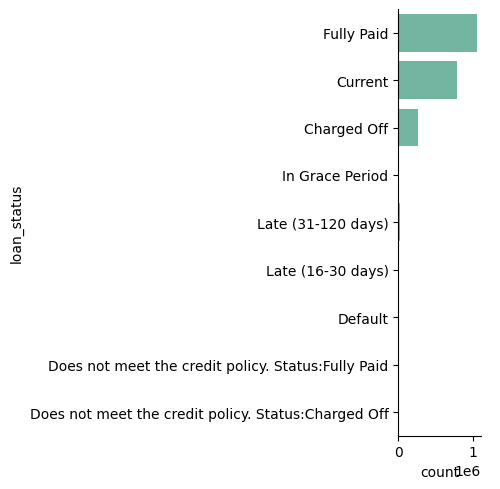

In [466]:
sns.set_palette(sns.color_palette("Set2"))
sns.catplot(y="loan_status",data=loan_df_cat, kind="count")

In [467]:
loan_df_cat.loan_status.value_counts()

loan_status
Fully Paid                                             1057295
Current                                                 787191
Charged Off                                             262215
Late (31-120 days)                                       19289
In Grace Period                                           7342
Late (16-30 days)                                         3843
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     34
Name: count, dtype: int64

The loans in the dataset are in 5 categories: Current, Fully paid, Charged-off, Default and Late.The scope of this project is a binary classification; therefore, Current loans are dropped. We'll use the current values later as a test set for predicting whether or not a borrower defaults. A closer look at the data revealed that default is when the borrower is late and charged off happens when the creditor gives up hope on getting the loan back. So, default is the beginning of the process which may or may not lead to charge off. Therefore, Charged-off and Default categories are combined in one category and is called Default.

In [468]:
loan_df_cat = loan_df_cat[~(loan_df_cat.loan_status=='Current')]

In [469]:
loan_df_cat.shape

(1352767, 38)

In [470]:
mapping = {'Late (31-120 days)':'Default', 'In Grace Period':'Default', 'Late (16-30 days)':'Default', 
             'Does not meet the credit policy. Status:Charged Off':'Default', 'Charged Off':'Default',
           'Does not meet the credit policy. Status:Fully Paid':'Fully Paid'}
loan_df_cat.loan_status.replace(mapping, inplace=True)

In [471]:
loan_df_cat.loan_status.unique()

array(['Fully Paid', 'Default'], dtype=object)

In [472]:
loan_df_cat.shape

(1352767, 38)

#### Loan Title

In [473]:
feature_describe(['title'])

,LoanStatNew,Description
95,title,The loan title provided by the borrower


In [474]:
loan_df_cat.title.value_counts()

title
Debt consolidation             662759
Credit card refinancing        251443
Home improvement                75138
Other                           67547
Major purchase                  24334
                                ...  
Life Perserver Loan                 1
NeverAgain                          1
Consolidate 3 loans                 1
notebook                            1
debt reduction/hone updates         1
Name: count, Length: 63153, dtype: int64

In [475]:
loan_df_cat.title= loan_df_cat.title.str.lower()
loan_df_cat_title_notna = loan_df_cat.title[loan_df_cat.title.notna()]

In [476]:
searchfor = ['consolidation', 'debt', 'bill']

In [477]:
loan_df_cat_title_notna.str.contains('|'.join(searchfor))

0           True
1          False
4          False
5           True
6           True
           ...  
2260688    False
2260690     True
2260691    False
2260692    False
2260697     True
Name: title, Length: 1336279, dtype: bool

In [478]:
# fill all null values with False
#debt_cons = loan_df_cat.title.str.contains('|'.join(searchfor)).fillna(False)
debt_cons = loan_df_cat_title_notna.str.contains('|'.join(searchfor))

In [479]:
debt_cons.value_counts()

title
True     742809
False    593470
Name: count, dtype: int64

In [480]:
loan_df_cat_title_notna[debt_cons]='debt consolidation'

In [481]:
loan_df_cat.title.unique().shape

(53304,)

In [482]:
searchfor = ['personal', 'business', 'vacation','wedding', 'car', 'auto', 'my', 'house', 'medical', 'purchase', 'home', 'pool']
#personal = loan_df_cat.title.str.contains('|'.join(searchfor)).fillna(False)
personal = loan_df_cat_title_notna.str.contains('|'.join(searchfor))

In [483]:
personal.value_counts()

title
False    881585
True     454694
Name: count, dtype: int64

In [484]:
loan_df_cat_title_notna[personal] = 'personal'

In [485]:
loan_df_cat_title_notna.str.contains('finance').value_counts()
# finance = loan_df_cat.title.str.contains('finance').fillna(False)
finance = loan_df_cat_title_notna.str.contains('finance')
loan_df_cat_title_notna[finance] = 'finance'

In [486]:
loan_df_cat_title_notna.str.contains('credit card', 'cc').value_counts()
#credit_card = loan_df_cat.title.str.contains('credit card').fillna(False)
credit_card = loan_df_cat_title_notna.str.contains('credit card')
loan_df_cat_title_notna[credit_card] = 'credit card'

In [487]:
loan_df_cat_title_notna.str.contains('pay off').value_counts()
#pay_off = loan_df_cat.title.str.contains('pay off').fillna(False)
pay_off = loan_df_cat_title_notna.str.contains('pay off')

loan_df_cat_title_notna[pay_off] = 'pay off'

In [488]:
index = ['debt consolidation', 'personal', 'finance', 'credit card', 'pay off']
loan_df_cat_title_notna[~(loan_df_cat_title_notna.isin(index))]='other'

In [489]:
loan_df_cat.title.unique()

array(['debt consolidation', 'business', 'major purchase', ...,
       'takeitaway', 'creditt card loan', 'debt reduction/hone updates'],
      dtype=object)

In [490]:
loan_df_cat.title.value_counts()

title
debt consolidation                     684002
credit card refinancing                251829
home improvement                        77690
other                                   67633
major purchase                          24629
                                        ...  
help me move!                               1
farmer 129                                  1
property management securities loan         1
need to refinance - please help             1
debt reduction/hone updates                 1
Name: count, Length: 53303, dtype: int64

In [491]:
loan_df_cat.title.isnull().sum()

16488

Since the other column (purpose) conveys the same pieces of information, we drop the title column.

In [492]:
loan_df_cat.drop('title', axis=1, inplace=True)

#### purpose

In [494]:
loan_df_cat.purpose.unique()

array(['debt_consolidation', 'small_business', 'major_purchase',
       'credit_card', 'other', 'home_improvement', 'house', 'vacation',
       'car', 'medical', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

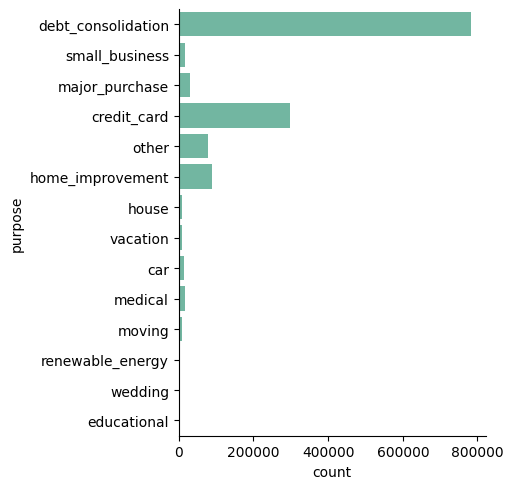

In [495]:
sns.catplot(y="purpose",data=loan_df_cat, kind="count")

In [496]:
loan_df_cat.purpose = loan_df_cat.purpose.str.lower()

In [497]:
loan_df_cat.purpose.isnull().sum()

0

In [498]:
# for some reasons, the join does not work and includes the credit card too 
loan_df_cat_temp =loan_df_cat
loan_df_cat_temp_no_credit = loan_df_cat_temp.purpose[~(loan_df_cat_temp.purpose.str.contains("credit_card"))]

In [499]:
searchfor = ['small_business', 'major_purchase', 'home_improvement', 'house', 
              'vacation','car', 'medical', 'moving', 'renewable_energy', 'wedding','educational']

In [500]:
personals = loan_df_cat_temp_no_credit.str.contains("|".join(searchfor))

In [501]:
loan_df_cat_temp_no_credit[personals].unique()

array(['small_business', 'major_purchase', 'home_improvement', 'house',
       'vacation', 'car', 'medical', 'moving', 'renewable_energy',
       'wedding', 'educational'], dtype=object)

In [502]:
loan_df_cat_temp_no_credit[personals] = 'other'

In [503]:
search = ["credit_card", "debt_consolidation", "other"]
loan_df_cat_temp.purpose[~(loan_df_cat_temp.purpose.str.contains("|".join(search)))].unique()

array(['small_business', 'major_purchase', 'home_improvement', 'house',
       'vacation', 'car', 'medical', 'moving', 'renewable_energy',
       'wedding', 'educational'], dtype=object)

In [504]:
loan_df_cat_temp.purpose[~(loan_df_cat_temp.purpose.str.contains("|".join(search)))] = loan_df_cat_temp_no_credit

In [505]:
loan_df_cat_temp.purpose.unique()

array(['debt_consolidation', 'other', 'credit_card'], dtype=object)

In [506]:
loan_df_cat = loan_df_cat_temp

#### sub_grade

In [507]:
loan_df_cat.sub_grade.unique()

array(['C4', 'C1', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2', 'A4',
       'E3', 'C5', 'A1', 'D4', 'F3', 'B4', 'D1', 'B3', 'D3', 'D5', 'A5',
       'F2', 'E4', 'D2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5'], dtype=object)

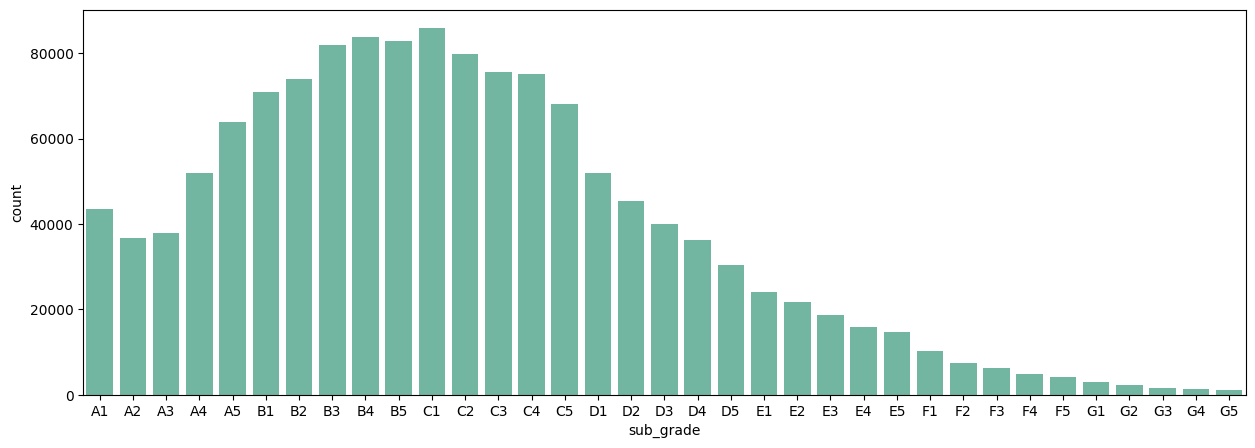

In [508]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x=loan_df_cat["sub_grade"],ax=ax,order=np.sort(loan_df_cat.sub_grade.unique()).tolist())
plt.show()

#### The length of employment (emp_length)

In [509]:
loan_df_cat.emp_length.unique()

array(['10+ years', '3 years', '4 years', '6 years', '7 years', '8 years',
       '2 years', '5 years', '9 years', '< 1 year', '1 year', nan],
      dtype=object)

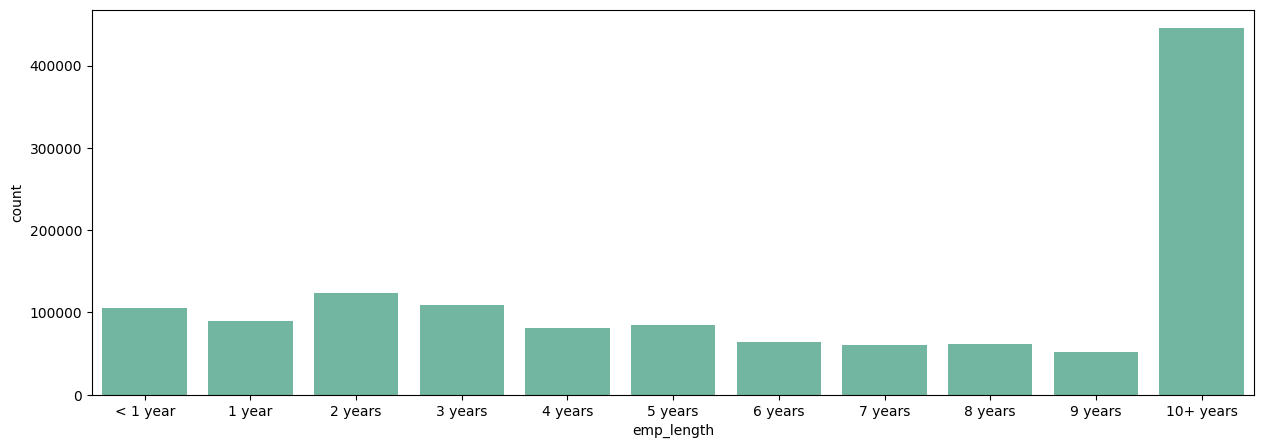

In [510]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x=loan_df_cat["emp_length"],ax=ax,order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years',
                                                    '7 years', '8 years', '9 years', '10+ years'])
plt.show()

#### Home Ownership

In [511]:
loan_df_cat['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [512]:
loan_df_cat['home_ownership'].replace(['ANY', 'NONE'], 'OTHER', inplace=True)

<Axes: xlabel='home_ownership', ylabel='count'>

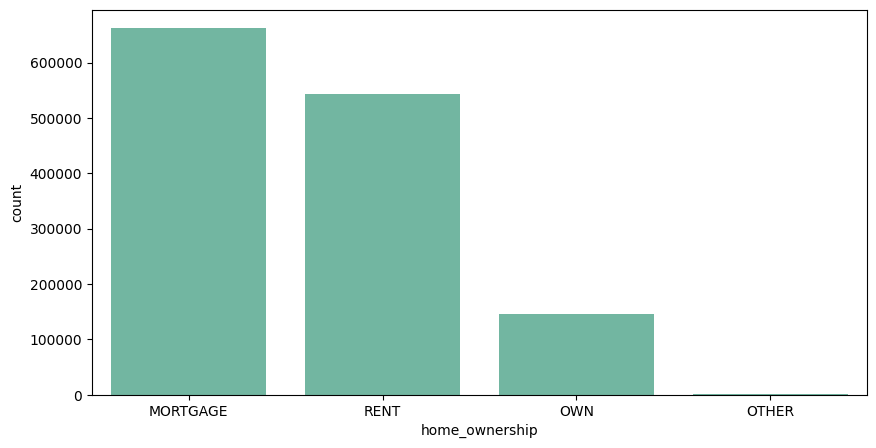

In [513]:
# Plotting home_ownership
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="home_ownership", data=loan_df_cat, ax=ax)

#### Verification status

In [514]:
feature_describe(['verification_status'])

,LoanStatNew,Description
112,verification_status,"Indicates if income was verified by LC, not verified, or if the income source was verified"


In [515]:
loan_df_cat.verification_status .unique()    

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

#### Initial list status

In [516]:
feature_describe(['initial_list_status'])

,LoanStatNew,Description
29,initial_list_status,"The initial listing status of the loan. Possible values are – W, F"


In [517]:
loan_df_cat.initial_list_status     

0          w
1          w
4          w
5          w
6          f
          ..
2260688    f
2260690    f
2260691    f
2260692    f
2260697    f
Name: initial_list_status, Length: 1352767, dtype: object

It is not clear what the initial list status is, but it is not something very important in our modeling for the risk of default. So, we'll drop this column too.

In [518]:
loan_df_cat.drop('initial_list_status', inplace=True, axis=1)

loan_df_cat includes all revised categorial variables (they have not been yet converted to numerical valus).

In [519]:
loan_df_cat.shape

(1352767, 36)

In [539]:
loan_df = loan_df_cat

### Check for duplication

In [540]:
duplicates = loan_df.duplicated(keep=False)

In [541]:
loan_df[duplicates]

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,earliest_cr_line,open_acc,mort_acc,annual_inc,issue_d,...,addr_state,loan_amnt,purpose,verification_status,tot_hi_cred_lim,pub_rec,delinq_2yrs,delinq_amnt,acc_now_delinq,bc_util


### Dropping the applications with missing data and checking the dimension.


In [563]:
get_missing_data(loan_df)

,count,missing %
emp_length,77070,5.697212
num_rev_accts,70277,5.195056
tot_hi_cred_lim,70276,5.194982
bc_util,64428,4.762683
mort_acc,50030,3.698346
pub_rec_bankruptcies,1365,0.100904
revol_util,880,0.065052
chargeoff_within_12_mths,145,0.010719
collections_12_mths_ex_med,145,0.010719
tax_liens,105,0.007762


In [565]:
loan_df = loan_df.dropna()

### Treating the dates

In [566]:
print(get_data_type(loan_df)['object_dtype'])

['earliest_cr_line', 'issue_d', 'grade', 'sub_grade', 'loan_status', 'term', 'emp_length', 'home_ownership', 'addr_state', 'purpose', 'verification_status']


In [567]:
loan_df[get_data_type(loan_df)['object_dtype']]

,earliest_cr_line,issue_d,grade,sub_grade,loan_status,term,emp_length,home_ownership,addr_state,purpose,verification_status
0,2003-08,2015-12,C,C4,Fully Paid,36 months,10+ years,MORTGAGE,PA,debt_consolidation,Not Verified
1,1999-12,2015-12,C,C1,Fully Paid,36 months,10+ years,MORTGAGE,SD,other,Not Verified
4,1998-06,2015-12,F,F1,Fully Paid,60 months,3 years,MORTGAGE,PA,other,Source Verified
5,1987-10,2015-12,C,C3,Fully Paid,36 months,4 years,RENT,GA,debt_consolidation,Source Verified
6,1990-06,2015-12,B,B2,Fully Paid,36 months,10+ years,MORTGAGE,MN,debt_consolidation,Not Verified
...,...,...,...,...,...,...,...,...,...,...,...
2260688,2004-07,2016-10,B,B2,Fully Paid,60 months,5 years,OWN,TX,other,Not Verified
2260690,2002-03,2016-10,C,C3,Fully Paid,60 months,9 years,MORTGAGE,CA,debt_consolidation,Not Verified
2260691,2011-06,2016-10,C,C4,Default,60 months,3 years,MORTGAGE,AZ,other,Source Verified
2260692,1997-08,2016-10,C,C1,Fully Paid,60 months,10+ years,RENT,NC,other,Not Verified


In [568]:
# date columns
date_col = ['earliest_cr_line', 'issue_d']

In [569]:
loan_df[date_col].dtypes

earliest_cr_line    object
issue_d             object
dtype: object

In [570]:
feature_describe(date_col)

,LoanStatNew,Description
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
35,issue_d,The month which the loan was funded


In [571]:
loan_df.issue_d

0          2015-12
1          2015-12
4          2015-12
5          2015-12
6          2015-12
            ...   
2260688    2016-10
2260690    2016-10
2260691    2016-10
2260692    2016-10
2260697    2016-10
Name: issue_d, Length: 1194547, dtype: object

In [578]:
loan_df = stringdate_to_datetime(loan_df, date_col)

In [579]:
loan_df[date_col].dtypes

earliest_cr_line    datetime64[ns]
issue_d             datetime64[ns]
dtype: object

### Heat Map of the numerical features 
To check if there is any correlation between numerical features, they are separated from the rest and a heat map is plotted.

In [581]:
dfnumeric = loan_df.select_dtypes(np.number)
dfnumeric.shape

(1194547, 25)

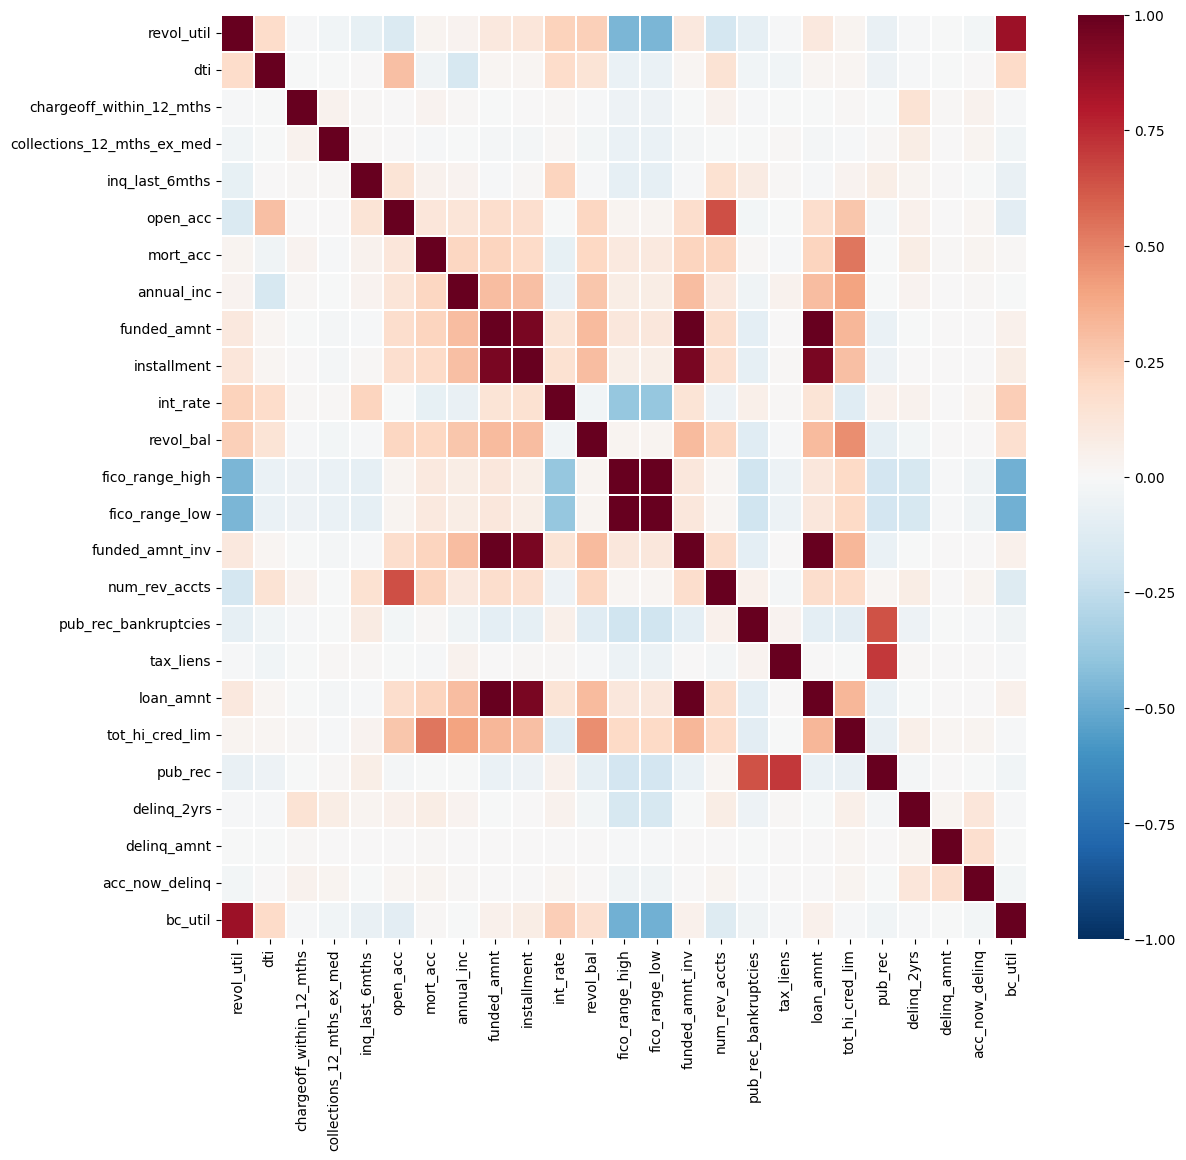

In [582]:
# Show a seaborn heatmap of correlations in dffloat
plt.figure(figsize = (13,12))
corr = dfnumeric.corr()
sns.heatmap(corr ,xticklabels=corr.columns, yticklabels=corr.columns,cmap="RdBu_r",linewidths=.3,vmin=-1, vmax=1);


#### Take away from this plot:

'fico_range_low' and 'fico_range_high' are highly correlated, so probably an average value can replace the low and high ranges. 

'funded_amount', loan_amount' and 'funded_amnt_inv' are HIGHLY correlated. Therefore, I will drop two of them.

'installment' and 'funded amount' are correlated, which is expected.

open account is correlated with number of revolving account, which is not surprising. 

#### Exploring the FICO score

A FICO score, is a numerical score that determines how likely a consumer will pay his or her bills. The scores are compiled by a company called Fair Isaac & Co., which began developing credit scores in the latter part of the 1950s. It ranges from 300 to 850, with 850 considered a perfect score. The higher your score, the better your odds of being approved for loans and lines of credit at the most favorable interest rates.

It is important to check if the reported high Fico range is higher than the reported low Fico range. To check this the difference of the two columns are estimated. It can be seen that there is not a negative difference.

In [593]:
loan_df.loc[(loan_df['fico_range_high'] - loan_df['fico_range_low']) < 0].values

array([], shape=(0, 36), dtype=object)

#### Check distribution of the features

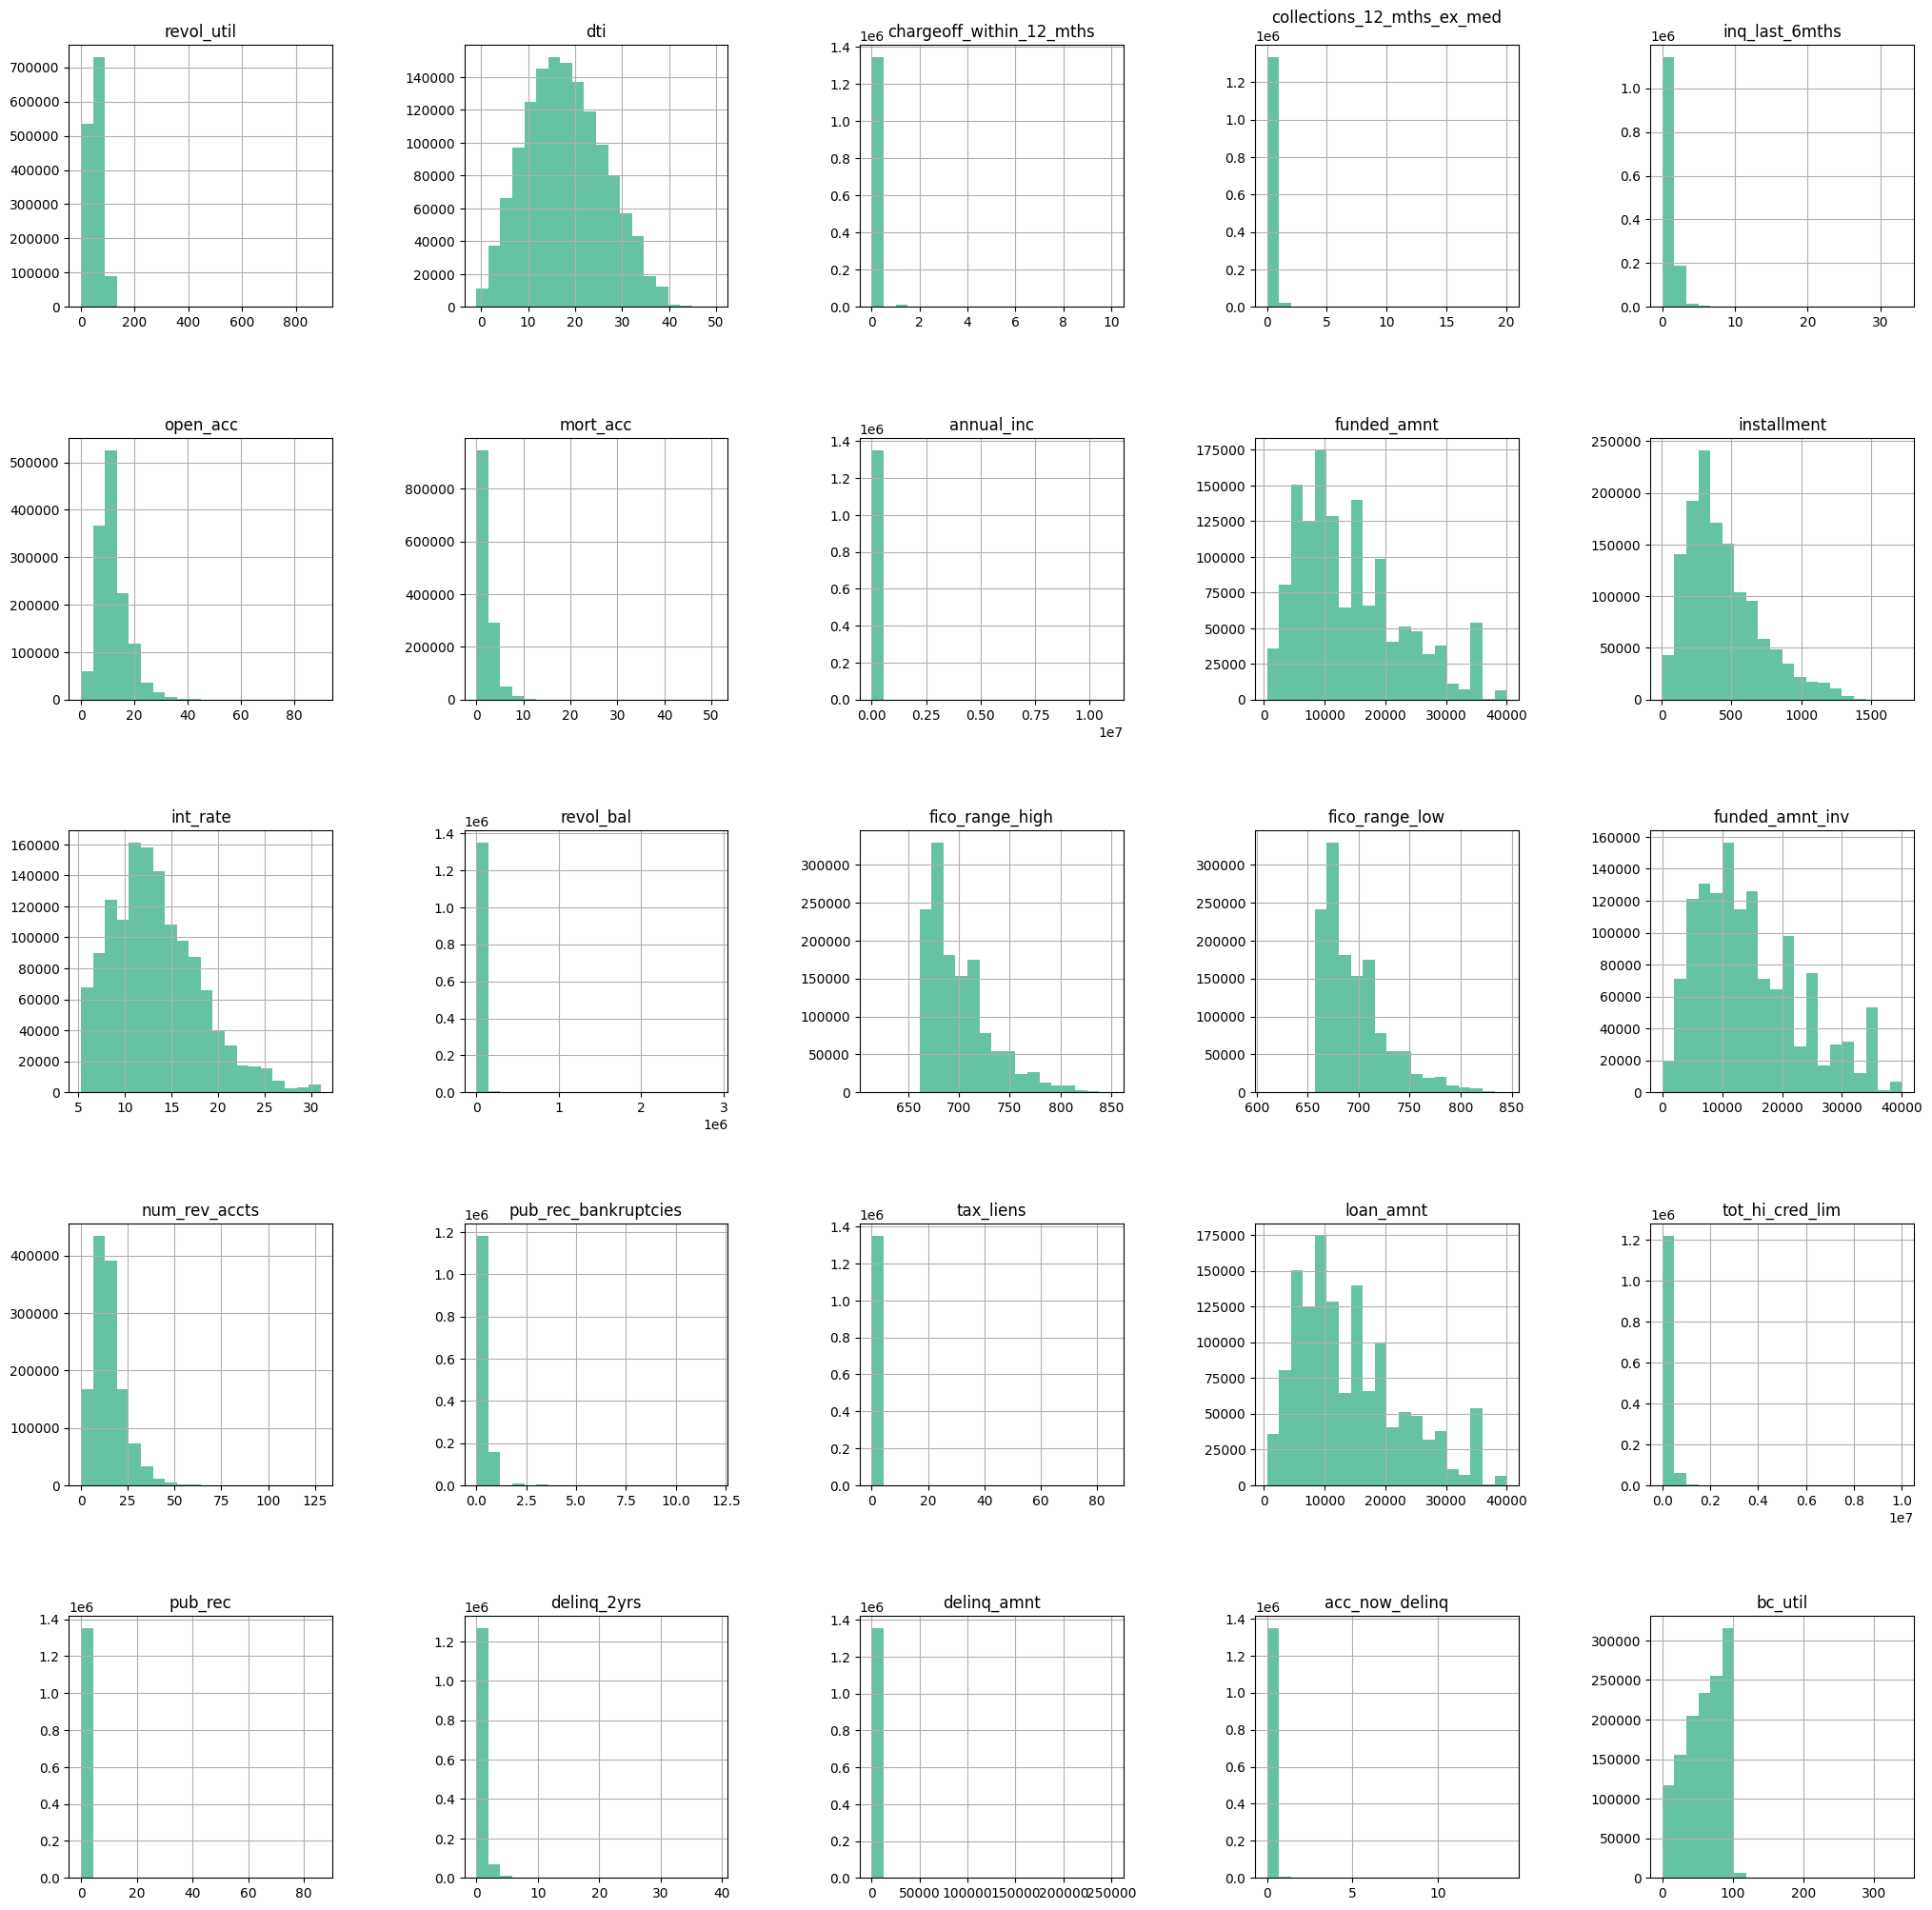

In [601]:
#fig, axes = plt.subplots(figsize=(25, 25) )
loan_df.select_dtypes(np.number).hist(figsize=(25, 25), bins=20)
plt.subplots_adjust(hspace=0.5, wspace=.5);

Some of the features such as charge_off_withon_12_mths, collections_12_mths_ex_med, annual_inc, revol_bal, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, pub_rec, delinq_2yrs, delinq_amnt, acc_now_delinq are very skewed. 

In [605]:
skewed_features = ['chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'annual_inc', 'revol_bal',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'pub_rec', 'delinq_2yrs', 'delinq_amnt', 'acc_now_delinq']

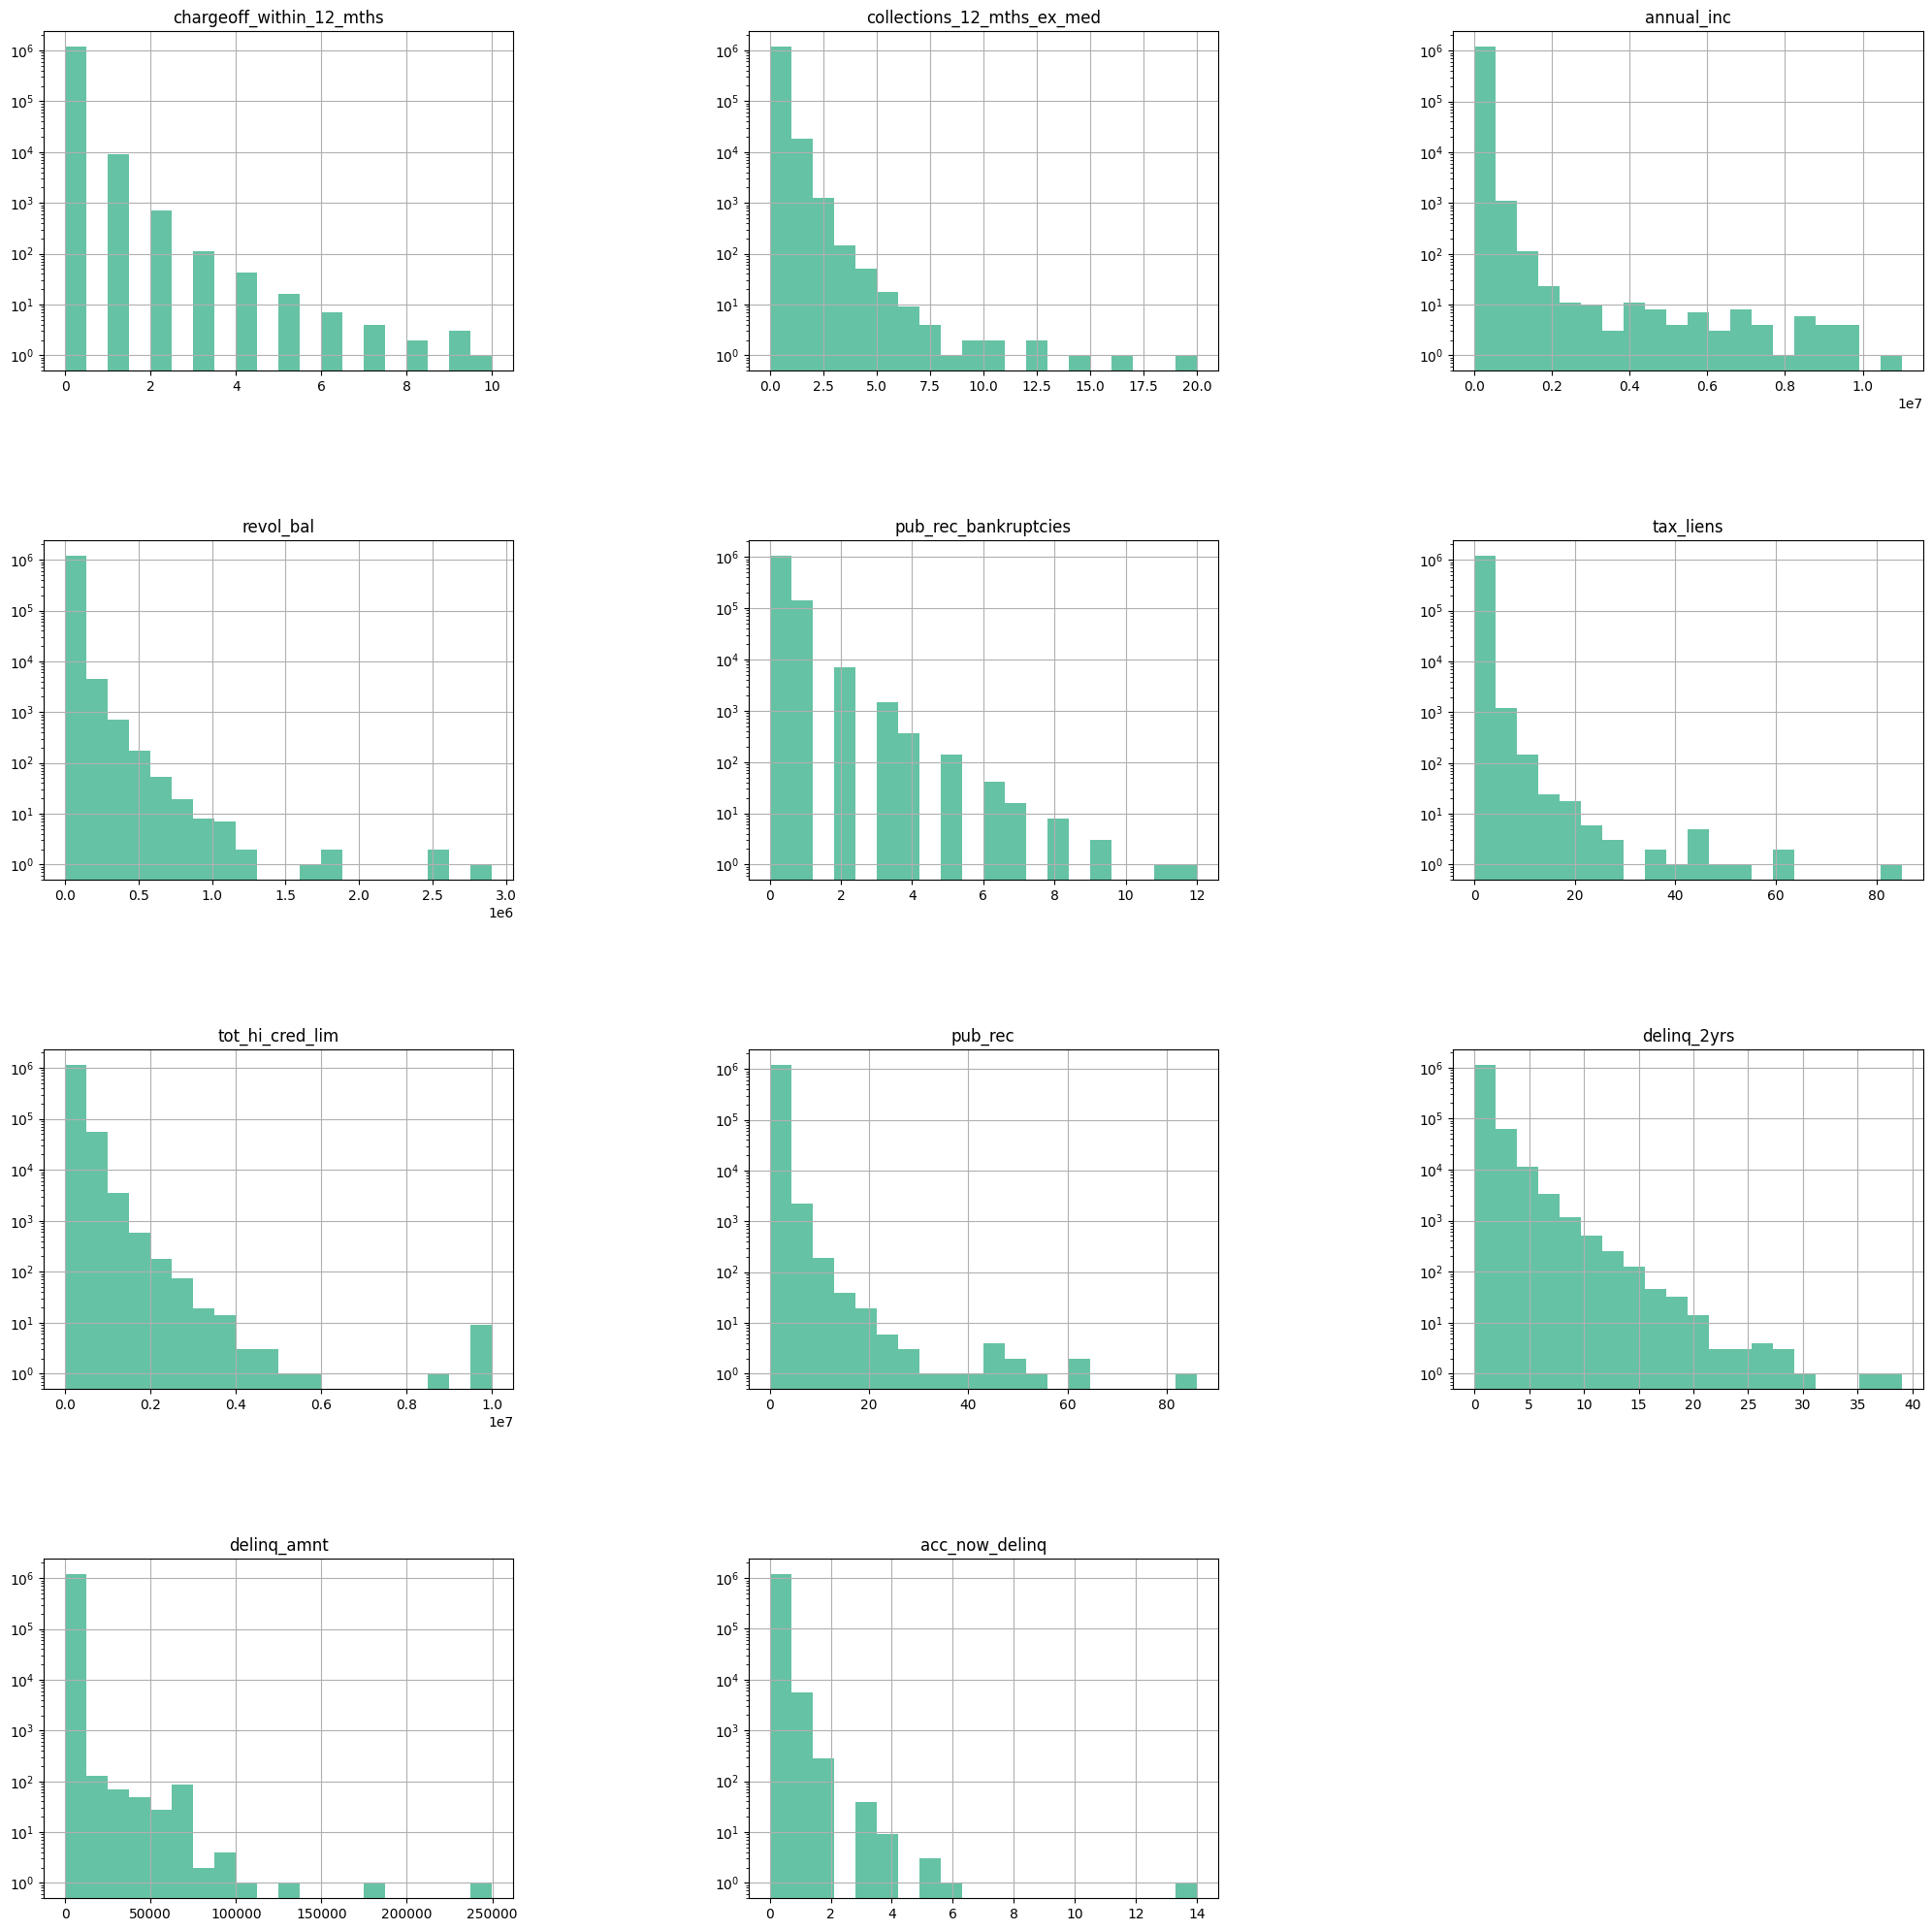

In [607]:
loan_df[skewed_features].hist(figsize=(25, 25), bins=20, log = True)
plt.subplots_adjust(hspace=0.5, wspace=.5);

All of these features show left skewness. We will explore this in the EDA part. However, I see lots of wird values, such as high
income (over 1M), or 14 delinquent accounts, 

In [611]:
feature_describe(['pub_rec'])

,LoanStatNew,Description
85,pub_rec,Number of derogatory public records


### Summary 
The original data file of the accepted loans has 151 columns and more than 2 million rows. Any columns that was not established prior to the decision was dropped. The focus is on the single applicants, therefore, join applications were also dropped.

A heat map of the numerical features show that 'fico_range_low' and 'fico_range_high' were highly correlated, as well as, 'installment' and 'funded amount', which is expected.

Histograms of the distributions of features did not show any abnormalities. catagorical data including loan_status and employment length were also plotted. Almost half of loans in our dataframe are paid in full. From the rest about 750,000 are current and more than 200,000 of loans are charged off, which is an early indication of default. There is only 30 loans with default status.

### Saving the wrangled frame
The final clean data frame is saved as a new file.

In [613]:
# Saving the new dataframe for easy future references:

SavePath = os.path.join(PROJ_ROOT,'data', 'wrangled', "cleaned_data.csv")
loan_df.to_csv(SavePath, sep ='\t')